# Build a Prediction of District's Median Mousing Price

#### Problem Framing:
**1.Supervised Learning: Each instance comes with an expected output.**

**2.Multiple Regression Problem: The system will use multiple features to predict a value.**

**3.Univariate Regression Problem: We are only trying to predict a single value for each district.**

## Information about the data:

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

### Performance Measure
**RMSE (Root Mean Square Error):** It gives an idea of how much error the system typically makes in its predictions. 

## Setup

In [1]:
# Python is >= 3.5
import sys
assert sys.version_info >=(3, 5)

# Scikit-Learn is >= 0.20
import sklearn
assert sklearn.__version__ >="0.20"

import numpy as np
import os

# To plot figures
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Where to save the figure/it can also be done manual
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Get the Data

In [2]:
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSE_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def featch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSE_PATH):
    """
    This function creates a "datasets/housing" directory in the workspace.
    Downloads the "housing.tgz" file.
    Extracts the "housing.csv" file from "housing.tgz" into the directory.
    """
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
featch_housing_data()

In [4]:
import pandas as pd

# This function returns a Pandas DataFrame with all the data
def load_housing_data(housing_path=HOUSE_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# Checking the object attribute and how many different values it has
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


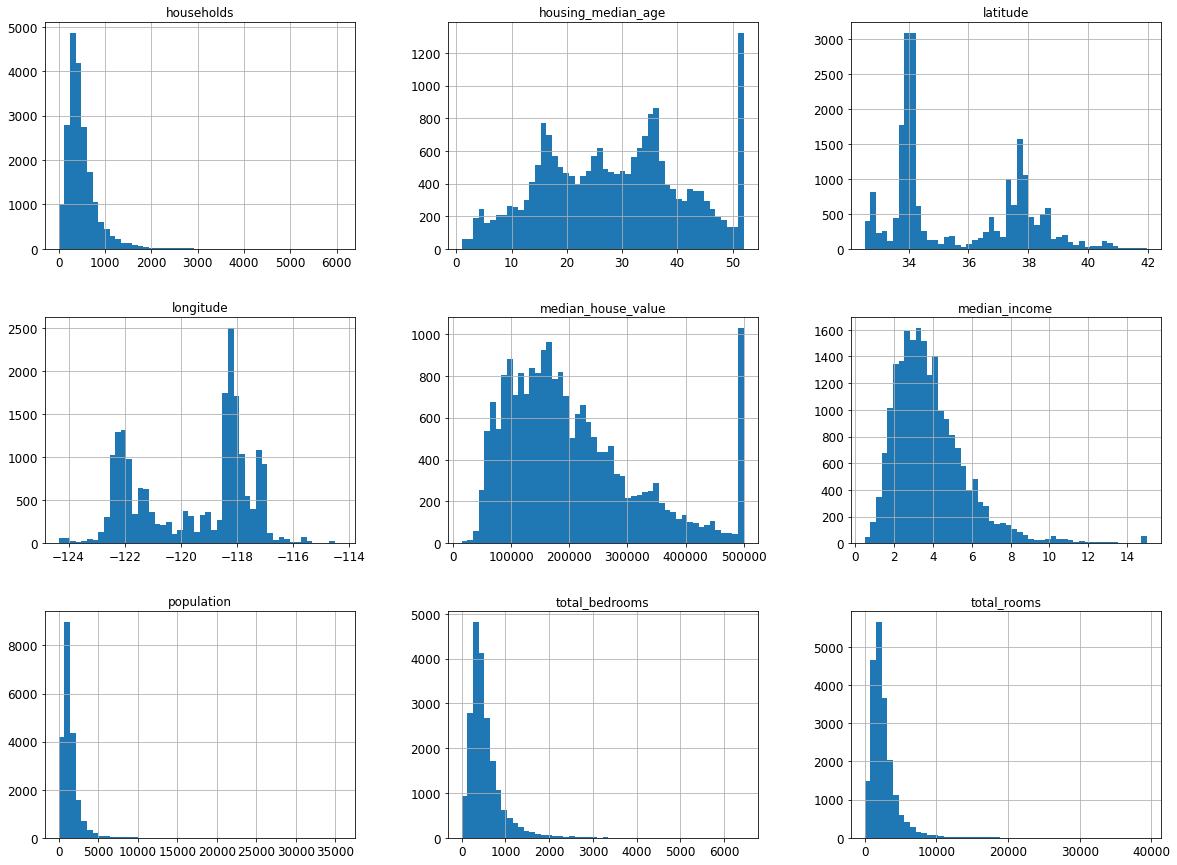

In [9]:
# Take a look at the type of data 
housing.hist(bins=50, figsize=(20, 15));

## Random Sampling with train_test_split()

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, 
                                       test_size=0.2,
                                       random_state=42)

In [11]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


## Stratefied Sampling
**Stratified Sampling:** the populatin is divided into homogeneous subgroups called **strata**,and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.


**Suppose the experts are saying that the "median_income" is very important in predicting house prices**

**Looking at the "median_income" values we can see that they are clustered around 1.5 and 6, but some go far past 6.**

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

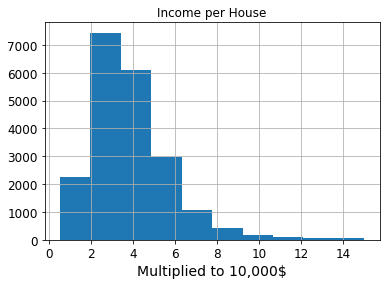

In [12]:
# Take a look at the "midean_income" histogram
housing["median_income"].hist()
plt.xlabel("Multiplied to 10,000$")
plt.title("Income per House");
housing.median_income.describe()

**We can create a "income_cat" category attribute with 5 categories (labeled from 1 to 5): cat. 1 range from 0 to 1.5 and so on...**

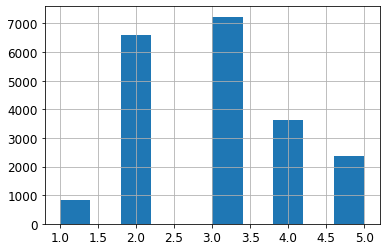

In [13]:
# Create the category and categorize using "pd.cut()"
housing["income_cat"] = pd.cut(housing.median_income,
                             bins=[0, 1.5, 3, 4.5, 6, np.inf],
                             labels=[1, 2, 3, 4, 5])

# Visualize "income_cat" category
housing.income_cat.hist();

**Now we are ready to do a stratified sampling based on the "income_cat" category.**

In [14]:
# Import Stratified Schuffle Split
from sklearn.model_selection import StratifiedShuffleSplit

# Instantiate 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
for train_index, test_index in split.split(housing, housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
len(strat_train_set), len(strat_test_set)

(16512, 4128)

In [16]:
# The precentage of the test data split in the categories
strat_test_set.income_cat.value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
# The precentage of all the data split into categories
housing.income_cat.value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

**Create a DataFrame to compare the Stratefied vs Random Sampling**

In [18]:
def income_cat_proportions(data):
    """
    Function to calculate the error of the strata and random samples
    """
    return data.income_cat.value_counts() / len(data)

# Split the data using random sampling method train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Create the comparison DataFrame
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()

compare_props["Random %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Stratified %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [19]:
print("The test set generated using stratified sampling has income category proportions almost identical to the full data set.")
print("The test set generated using purely random sampling is skewed.")
compare_props

The test set generated using stratified sampling has income category proportions almost identical to the full data set.
The test set generated using purely random sampling is skewed.


,Overall,Stratified,Random,Random %error,Stratified %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


**Now we can remove the "income_cat" attribute so the data is back to its original state**

In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize Data to Gain Insights
**The test set has to be put aside**

**We will only be exploring the training set**

In [21]:
housing = strat_train_set.copy()

#### Visualize Geographical Data
* Since there is geographical information (latitude and logitude), it is a good to create a scatter plot to visualize the data.

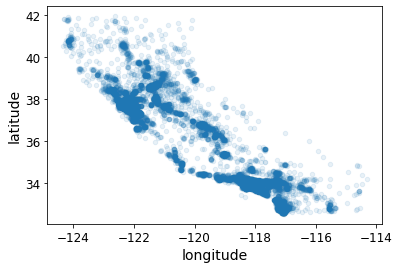

In [22]:
# "alpha=0.1" makes is easier to visualize the places were there is high density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

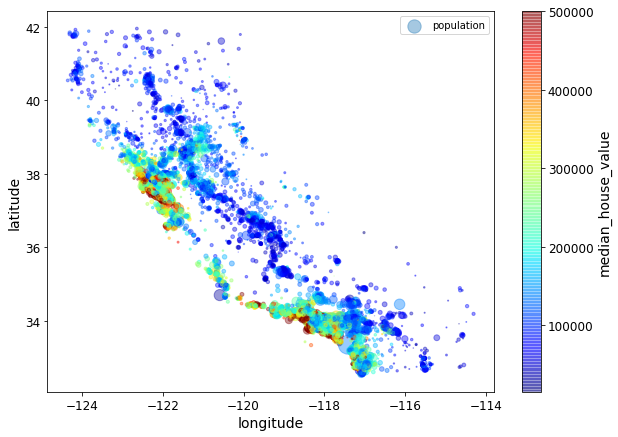

In [23]:
# Make a scatter plot based on the geographical data incloding the house values
# "s" --> represents the districts population
# "c" --> represents the price 
# "cmap=plt.get_cmap("jet") --> predefined color map called "jet"
# "sharex=False" --> fixes a display bug if the x-axis and legend is not displayed
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
              s=housing.population / 100, label="population", figsize=(10, 7),
              c = "median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.legend();

**Plot the above scatter plot with a image of the California map**


In [24]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to _end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading" + filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

Downloadingcalifornia.png


('.\\images\\end_to _end_project\\california.png',
 <http.client.HTTPMessage at 0x212c086eca0>)

Saving figure california_housing_price_plot


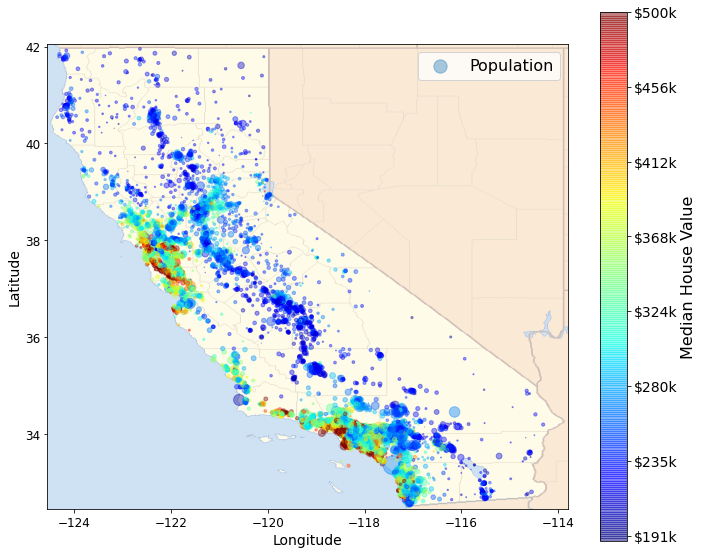

In [25]:
# Import the image
import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join(images_path, filename))

# Plot
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,8),
                  s=housing.population / 100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)

# "extent" ---> range of x and y 
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# Set a variable for the "median_house_value"
prices = housing.median_house_value

# Split the price in 11 categories
tick_values = np.linspace(prices.min(), prices.max(), 12)

cbar = plt.colorbar(ticks=tick_values/prices.max())

# Set the cbar tick labels (iterate through tick_values)
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)

cbar.set_label("Median House Value", fontsize=16)

plt.legend(fontsize=16)

# Save image
save_fig("california_housing_price_plot")
plt.show();

**The data above tells us that the housing prices are verymuch related to the location and population density.**

**A cluster algorithm should be useful for detecting the main cluster and for assing new features that mesure the proximity to the cluster center.**

**The ocean proximity may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a somple rule.**

## Looking for Correlations

Since the data is not too large, we can easily compute the **standard correlation coefficient** using **corr()**

In [26]:
corr_matrix = housing.corr()

# Check how much each attribute correlates with the median house value
print("The closer to 1, the stronger positive correlation")
print("The closer to -1, the stronger negative corelation")
print("The closer to 0, the less correlation")
print("The correlation has nothing to do with the slope of the line")
corr_matrix["median_house_value"].sort_values(ascending=False)

The closer to 1, the stronger positive correlation
The closer to -1, the stronger negative corelation
The closer to 0, the less correlation
The correlation has nothing to do with the slope of the line


median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

#### Cheking correlations with Pandas

Since there are 11 numerical attributes we would get 11^2 = 121 plots.

So focus on a few attributes that seem most correlated with the median husing value

Saving figure scatter_matrix_plot


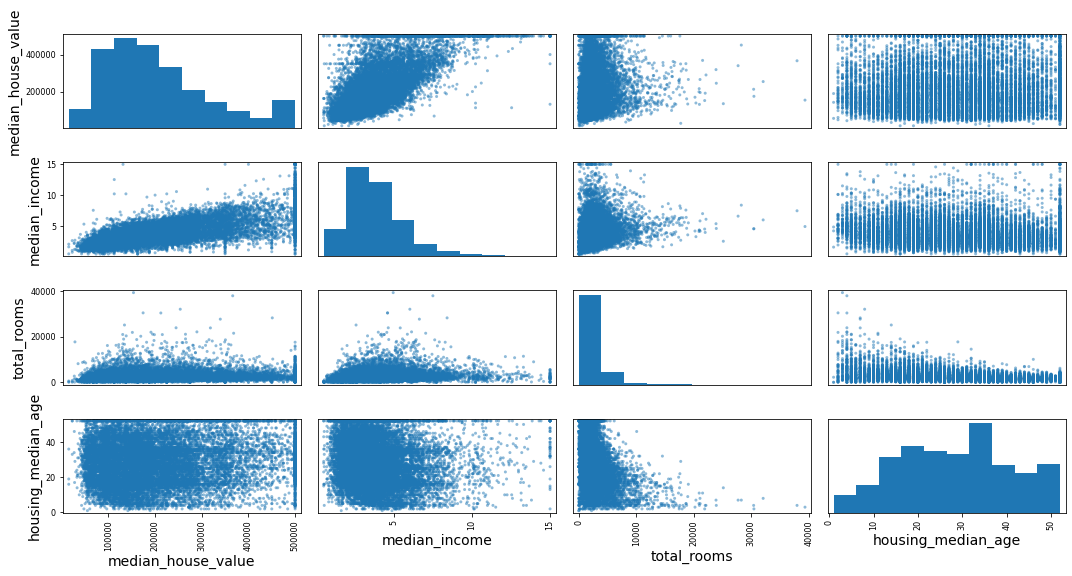

In [27]:
from pandas.plotting import scatter_matrix

# Instantiate most correlated attributes
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

# Plot with Pandas
scatter_matrix(housing[attributes], figsize=(15, 8))
save_fig("scatter_matrix_plot");

**From above we see:**

The most promissing attribute to predict the median house value is the median income

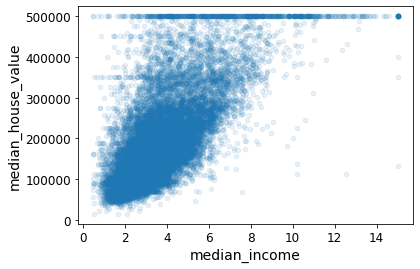

In [28]:
# Scatter plot median_income and median_house_value
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

## Experimenting with Attribute Combinations

**One last thing before preparing the data for Machine Learning algorithm is to try out various attribute combinations.**

Ex:
1. The total num. of rooms in a district is not very useful if we don't know how many houselods ther are. 
   We want the num. of rooms per household.
2. The total num. of bedrooms by itself is not very useful.
   We want to compare it to the number of rooms.
3. Also attribute combination between the population(total number residing within one block) per household

In [29]:
# Create the new attributes(columns)
housing["rooms_per_household"] = housing.total_rooms / housing.households
housing["bedroom_per_rooms"] = housing.total_bedrooms / housing.total_rooms
housing["population_per_household"] = housing.population / housing.households

In [30]:
# Check the correlation with the new columns incouded
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_rooms          -0.259984
Name: median_house_value, dtype: float64

**The new "bedroom_per_rooms" attribute is nuch more correlated with the "median_house_value" than the "total_rooms" or "total_bedroom".**
* This round of exploration does not have to be absolutely thorough.
* The point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype.
* Once the prototype is up and running, you can analyze its output and gain more insights and come back to this exploration step.

# Prepate the Data for Machine Learning Algorithm
**Its's good practice to write functions and not do it manually:**
* This will allow to reproduce these transformations easily on any dataset (if you get fresh data).
* You will gradually build a library of transformation functions that can be reused in future projects.
* They can be used in live systems to transform the new data before feeding it to an algorithm.
* This will make it possible to easilytry various transforamtions and see which combination of transformations works best.

In [31]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedroom_per_rooms,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [32]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [33]:
# Revert to clean training set and split in to predictors and labels (X/y)
# "drop()" creates a copy of the data and does not effect "strat_train_set"
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Clean the Data
**Most Machine Learning algorithms cannot work with missing features.**

The "total_bedrooms" attribute has some missing values.

**There are 3 options:**

* **Using Pandas:**

**1. Get rid of the coresponding rows(districts):** 

<font color='green'>housing.dropna(subset=["total_bedrooms"])</font>


**2. Get rid of the whole column(attribute):**

<font color='green'>housing.drop("total_bedrooms", axis=1)</font>


**3. Set the missing values to some value (mean, median, zero, etc.):** 

<font color='green'>median = housing["total_bedrooms"].median()</font>

<font color='green'>housing["total_bedrooms"].fillna(median, inplace=True)</font>

* **Scikit-Learn:**

**SimpleImputer: Class to take care of missing values**

In [34]:
from sklearn.impute import SimpleImputer

# Instantiate and set "strategy=median" to fill the missing values with the midean of its column
imputer = SimpleImputer(strategy="median")

**Since the median can be computed only on numerical attributes, create a copy of the data without the text attributes.**

In [35]:
# Drop "ocean_proximity": 2 ways to do it:
# 1.
# housing_num = housing.select_dtypes(include=[np.number])
#2.
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [36]:
# Fit the imputer instance
imputer.fit(housing_num)

SimpleImputer(strategy='median')

**The imputer has simply computed the median of each column(attribute) and stored the results in its <font color='red'>statistic_</font> instance variable.**

In [37]:
# Check the computer medians
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [38]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

**Now we can use this trained imputer to transform the training set by replacing missing values with the larned medians.**

In [39]:
X = imputer.transform(housing_num)

In [40]:
housing_train = pd.DataFrame(X, 
                             columns=housing_num.columns,
                             index=housing_num.index)
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [41]:
housing_train.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

## Handling Text and Categorical Attributes
**There is just one text attribute "ocean_proximity"**

In [42]:
# Pulling/taking a look at the text category
housing_cat = housing[["ocean_proximity"]]  #"[[]]" is has to be a 2D array
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


**From above we see: there are limited number of possible values, each of which represents a category.**

**This attribute is a categorical attribute.**

**We could use: <font color='red'>OrdinalEncoder</font>.**


In [43]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoder = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoder

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [44]:
# Check the list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**One issue with this representation is that ML algorithm will assume that 2 nearby values are more similar than two distant values.**

**This may be fine in ordered categories like "bad", "average", "good", "excellent", but not in this case.**

**In our example categories 0 and 4 are more similar than categoreis 0 and 1.**

<font color='green'>**A common solution is to create a binary attribute per category:**</font>

    * One attribute equals 1 when the category is "<1H OCEAN", and others 0., and so on...
    
**This is called: <font color='red'>one-hot encoding</font>.**(Because only 1 attribute will be 1(hot), while the others will be 0(cold).

In [45]:
# Import "OneHotEncoder"
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [46]:
# To get a list of the categories
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Costum Transformers
**Although Sciki-Learn provides many useful transformers, we need to write our own for tasks like (custom cleanup operations or combining specific attributes).**

**Scikit-Lear relies on duck typing (not inheritance).**

**We need to create a "class" and implement 3 methods:**
* fit()
* transform()
* fit_transform()

**We can get <font color='red'>fit_transformer()</font> by adding <font color='red'>TransformerMixin</font> as base class.**

**By adding <font color='red'>BaseEstimator</font> as a base class, we will get two extra methods <font color='red'>get_params()</font> and <font color='red'>set_params()</font> that will be useful for automatic hyperparameter tuning.**

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

# "ix" stands for index. Like this we grab the entire column needed
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Transformer class that adds the combined attributes
    This transformer has only one hyperparameter: add_bedrooms_per_room
    """
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X):
        """
        X = housing_train DataFrame
        """
        return self
    
    def transform(self, X, y=None):
        """
        Add columns:
        1. rooms_per_household by deviding total_rooms to households
        2. population_per_household by dividing population to households
        """
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            """
            If add_bedrooms_per_room is set to True
            """
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            """
            If add_bedrooms_per room is set to False
            """
            return np.c_[X, rooms_per_household, population_per_household]

# Instantiate the class
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

# Use the transform funtion within the class
housing_extra_attribs = attr_adder.transform(housing.values)

**The hyperparameter <font color='red'>add_bedrooms_per_room</font> in the transformer above is set to <font color='red'>True</font>. This will allow us to easily find out whether adding this attribute helps the Machine Learning algorithm or not.**

In [51]:
# Create a DataFrame with the new attributes
housing_extra_attribs = pd.DataFrame(housing_extra_attribs,
                                        columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
                                        index=housing.index)

housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Feature Scaling
**One of the most important transformations to apply to data is <font color='green'>feature scaling</font>. Machine Learning algorithms don't perform well when the input numerical attributes have very different scales.**

This is the case for the housing data: the total nuumber of rooms ranges from about 6 to 39,320, while the median income only ranges from 0 to 15.

**There are two common ways to get all attributes to have the same scale:**
1. <font color='green'>min-max scaling</font>
2. <font color='green'>standardization</font>

#### <font color='green'>Min-max (normalization):</font>
**Values are shiffted and rescaled so that they end up ranging from 0 to 1, by subtracting the min() value and dividing by the max() minus min().**

**Scikit-Learn provides a transformer <font color='red'>MinMaxScaler</font>. It has a <font color='red'>feature_range</font> hyperparameter that lets you change the range if you don't want 0 to 1.**

#### <font color='green'>Standardization:</font>
**It doesn't bound values to a specific range, which my be a problem for some algorithms (e.g. neural networs often expect values from 0 to 1), but its is much less affected by outliers.**

**Sciki-Learn provides a transformer <font color='red'>StandardScaler</font>.**

## Transformation Pipelines
**There are many data transformation steps that need to be executed in the right order.**

**Scikit-Learn provides the <font color='red'>Pipeline</font> class.**

**The <font color='red'>Pipeline</font> constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformed.**

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),  # takes care of the missing numerical values
        ('attribs_adder', CombinedAttributesAdder()),  # Combines attributes
        ('std_scaler', StandardScaler()),  # Scales the data
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

### A single transformer to handle all columns and applying the appropriate transformations
**<font color='red'>ColumnTransformer</font> works great with Pandas DataFrame.**

**It requires a list of tuples:**
1. <font color='green'>A name (it can be anything)</font>
2. <font color='green'>A transformer</font>
3. <font color='green'>A list of names of columns that the transformer should be applied to.</font>

In [55]:
from sklearn.compose import ColumnTransformer

# Numerical columns
num_attribs = list(housing_num)

# Categorical columns
cat_attribs = ["ocean_proximity"]

# Instantiate ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

# Apply the ColumnTransformer to the housing data
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

**After framing the problem, exploring the data, sampling a training and a testing set, writting transformation pipelinesto clean and prepare the data automatically, we can select and train a Machine Learning model.**

## Training and Evaluating in the Training Set

### 1.0 Train a Linear Regression Model

In [59]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [75]:
# Try the full preprocessing pupeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

# Put the data in to the pipeline for transformation
some_data_prepared = full_pipeline.transform(some_data)

lin_reg_data = lin_reg.predict(some_data_prepared)
print("Predict:", lin_reg_data)  # Predicted

Predict: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [76]:
# Labels
lin_reg_labels = list(some_labels)
print("Labels:", lin_reg_labels)

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


**It works even tho the predictions are off**

#### Measure this Model's RMSE on the Whole Training Data
**Using <font color='red'> mean_squared_error()</font> function.**

In [92]:
from sklearn.metrics import mean_squared_error

# Predict the whole training data
housing_predictions = lin_reg.predict(housing_prepared)

# mean-squared-error
lin_mse = mean_squared_error(housing_labels, housing_predictions)

# root-mean-squared-error
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

**Most district's "median_housing_values" range between 120,000 and 265,000 so a typical error of 68,628 is not very satisfying.**

**<font color='green'>This is an example of a model underfitting the training data.</font>**

**This means:**
1. <font color='green'>The features don't provide enough information.</font>
2. <font color='green'>The model is not powerful enough.</font>

**The main ways to fix underfitting are:**
1. <font color='green'>Select a more powerful model.</font>
2. <font color='green'>Feed the training algorithm with better features.</font>
3. <font color='green'>Reduce the constrains on the model (simplify the model)</font>

### 1.1 Train a DecisionTreeRegressor
**This model is capable of finding complex nonlinear relationships in the data.**

In [93]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [94]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

**Could this model be perfect?**

**It is more likely that the model has badly overfit the data.**

### Better Evaluation Using Cross-Validation
**One way to evaluate would be to use the <font color='red'> train_test_split()</font> function to split the training set into a smaller training set and a validation set.**

**A great alternative is to use <font color='green'>K-fold cross-validation</font> feature**

**It randomly splits the training set into 10 distinct subsets called <font color='green'>folds</font>, than it trains and evauates the model 10 times, picking a different fold evaluating every time and training on the other 9 folds.**

**The result is an array containing the 10 evaluation scores.**

In [108]:
from sklearn.model_selection import cross_val_score

np.random.seed(42)

scores = cross_val_score(tree_reg,   # The object to use to fit the data
                         housing_prepared,   # The data to fit
                         housing_labels,    # The target variable to try to predict
                         scoring="neg_mean_squared_error",     
                         cv=10)    # Number of folds

# "(-scores)" 
tree_rmse_scores = np.sqrt(-scores)

In [109]:
# Check the results
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("STD:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [70194.33680785 66827.44875653 70943.83549475 70236.44866746
 72219.36760134 75133.84314832 69784.4396021  71606.6771986
 78265.0939755  70510.49230819]
Mean: 71572.19835606452
STD: 2980.162774754496


In [110]:
# Compute the same score for the Linear Regression model
np.random.seed(42)

lin_scores = cross_val_score(lin_reg,
                             housing_prepared,
                             housing_labels,
                             scoring="neg_mean_squared_error",
                             cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
STD: 2731.674001798349


### 1.2 Train a RandomForestRegressor Model
**Random Forest works by training many Decision Trees on random subsets of the features, then averaging out their predictions.**

**Building a model on top of many other models is called <font color='green'>Ensemble Learning</font>, and it is often a great way to push ML algorithms even further.**

In [126]:
np.random.seed(42)
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [127]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [128]:
from sklearn.model_selection import cross_val_score
np.random.seed(42)

forest_scores = cross_val_score(forest_reg,
                                housing_prepared,
                                housing_labels,
                                scoring="neg_mean_squared_error",
                                cv=10)

forest_rsme_scores = np.sqrt(-forest_scores)
display_scores(forest_rsme_scores)

Scores: [49519.80364233 47309.13776959 50034.83275085 52544.23031502
 49626.31360372 52857.15469881 48914.19518053 47616.59182503
 53171.29315463 50220.98938807]
Mean: 50181.454232857155
STD: 1971.9257244522523


**Note that the score on the training set is much lower than on the validation set, meaning that the model is still overfitting the training set.**

## Fine-Tune the Model

### 1.0 Grid Search
**For this example:**

**<font color='red'>param_grid</font> tells Scikit-Learn to evaluate 3 x 4 = 12 combinations of the values specified in the first dictionary, then try all 2 x 3 = 6 combinations in the secound dictionry but this time with the <font color='red'>bootstrap</font> set to <font color='red'>False</font>.**

**The <font color='green'>GridSearchCV</font> will explore 12 + 6 = 18 combinations of <font color='green'>RandomForestRegressor</font> hyperparameter values, and it will train each model 5 times, so, 18 x 5 = 90 rounds of training.**

In [141]:
from sklearn.model_selection import GridSearchCV
np.random.seed(42)
# Set parameters
param_grid = [
    {"n_estimators": [50, 70, 100], "max_features": [6, 8, 10, 12]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [6, 8, 10, 12],
                          'n_estimators': [50, 70, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [142]:
# Get the best parameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 70}

In [143]:
# Get the best estimators
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=70)

In [144]:
# Evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49740.50971399434 {'max_features': 6, 'n_estimators': 50}
49329.43490052001 {'max_features': 6, 'n_estimators': 70}
49387.93281947358 {'max_features': 6, 'n_estimators': 100}
49662.37370331517 {'max_features': 8, 'n_estimators': 50}
49433.15668771575 {'max_features': 8, 'n_estimators': 70}
49449.50255853943 {'max_features': 8, 'n_estimators': 100}
49515.37749054467 {'max_features': 10, 'n_estimators': 50}
49702.27395571937 {'max_features': 10, 'n_estimators': 70}
49414.43326623195 {'max_features': 10, 'n_estimators': 100}
50179.20068771513 {'max_features': 12, 'n_estimators': 50}
50007.3543348469 {'max_features': 12, 'n_estimators': 70}
49739.6320603559 {'max_features': 12, 'n_estimators': 100}
62400.58654757241 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54425.07346840094 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59501.512378517546 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52447.028429754944 {'bootstrap': False, 'max_features': 3, 'n_e

**The RMSE for this combination is 49329.4349, slightly better than the default hyperparameter score 50181.4542.**

### 1.1 Randomized Search
**The <font color='green'>GridSearchCV</font> approach is fine when you're few combinations, but when the hyperparameter search space is large, it is ofter preferable to use <font color='green'>RandomizedSearchCV</font>.**

**Instead of trying out all possible combinations , it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.**

**This approach has two main benefits:**
* <font color='green'>If you let the randomized search run for, say, 1000 iterations, this approach will explore 1000 different values for each hyperparameter.</font>
* <font color='green'>Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.</font>

In [155]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

np.random.seed(42)

param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8)
}

forest_reg = RandomForestRegressor()

rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring="neg_mean_squared_error")

rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000212C5583BB0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000212C4C793A0>},
                   scoring='neg_mean_squared_error')

In [157]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [156]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49068.776305928885 {'max_features': 7, 'n_estimators': 180}
51223.13027956996 {'max_features': 5, 'n_estimators': 15}
50631.56911585929 {'max_features': 3, 'n_estimators': 72}
50577.278136507186 {'max_features': 5, 'n_estimators': 21}
49181.87219093771 {'max_features': 7, 'n_estimators': 122}
50951.26889914178 {'max_features': 3, 'n_estimators': 75}
50500.9863937211 {'max_features': 3, 'n_estimators': 88}
49397.185602762445 {'max_features': 5, 'n_estimators': 100}
50448.33421137178 {'max_features': 3, 'n_estimators': 150}
62972.129486636375 {'max_features': 5, 'n_estimators': 2}


## Analyze the Best Model and Their Errors
**You will often gain good insights on the problem by inspecting the best model.**

**In this example the <font color='green'>RandomForestRegressor</font> can indicate the relative importance of each attribute for making accurate predictions.**

In [163]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.36571884e-02, 6.52754213e-02, 4.28943193e-02, 1.66653925e-02,
       1.57258219e-02, 1.62100248e-02, 1.51462673e-02, 3.51819132e-01,
       5.16263760e-02, 1.08905667e-01, 6.72319057e-02, 1.08800984e-02,
       1.57261106e-01, 8.76590964e-05, 2.52577736e-03, 4.08784344e-03])

In [166]:
# Display this importance scores next to their corresponding attribute names
extra_attribs = ["rooms_per_hhould", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(features_importance, attributes), reverse=True)

[(0.35181913193443193, 'median_income'),
 (0.15726110553677183, 'INLAND'),
 (0.10890566713705806, 'pop_per_hhold'),
 (0.07365718842069743, 'longitude'),
 (0.06723190574567989, 'bedrooms_per_room'),
 (0.0652754212879223, 'latitude'),
 (0.05162637595158798, 'rooms_per_hhould'),
 (0.042894319256484334, 'housing_median_age'),
 (0.016665392490366773, 'total_rooms'),
 (0.016210024750986304, 'population'),
 (0.01572582192770132, 'total_bedrooms'),
 (0.015146267287035579, 'households'),
 (0.01088009837588211, '<1H OCEAN'),
 (0.004087843441905513, 'NEAR OCEAN'),
 (0.0025257773591285354, 'NEAR BAY'),
 (8.765909636028563e-05, 'ISLAND')]

**With this information, we may want to try dropping some of the less useful features.**

**We should also look at specific errors that your system makes, thentry to understand why it makes them and what could fix the problem(adding extra features, getting rid of uninformative ones, cleaning up outliers, etc.).**



## Evaluate Your System on the Test Set
**Evaluate the final model on the test set.**
1. <font color='green'>Get the predictors and the labels from the test set.</font>
2. <font color='green'>Run the <font color='red'>full_pipeline</font> to transform the data (call <font color='red'>transform()</font>, not <font color='red'>fit_transform()--we don't want to fit the test set</font>).</font> 
3. <font color='green'>Evaluate on the test set.</font>

In [168]:
final_model = rnd_search.best_estimator_

# Split the data
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Transform X_test
X_test_prepared = full_pipeline.transform(X_test)

# Predict 
final_predictions = final_model.predict(X_test_prepared)
final_mse =mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

46946.661900648345

### Check how precise this estimate is
**Compute 95% confidence interval using <font color='red'>scipy.stats.t.interval()</font>.**

In [169]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

array([44968.96264473, 48844.34998938])